In [1]:
"""
Imports
"""
import sys
print(f"Python:\t{sys.version}")
import numpy as np
print(f"Numpy:\t\t{np.__version__}")
import tensorflow as tf
print(f"Tensorflow:\t{tf.__version__}")
import keras
print(f"Keras:\t\t{keras.__version__}")

import os
import matplotlib.pyplot as plt
from keras import Sequential
from keras import layers

Python:	3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
Numpy:		1.24.3
Tensorflow:	2.10.0
Keras:		2.10.0


In [2]:
"""
Options
"""
model_name = "DemooNet_8c_3d_60e_32b"

image_width = 128
image_height = 128
channels_dim = 3
classes_dim = 6
batch_size = 32

validation_split = 0.2
base_learning_rate = 0.001
epochs_total = 60

shape = (image_height, image_width, channels_dim)


In [3]:
"""
Pathing
"""
SPECTROGRAMS_DIR = "../data/spectrograms/combined"
TF_MODELS_DIR = "../data/models_tf"
TFLITE_MODELS_DIR = "../data/models_tflite"

In [4]:
"""
Load data
"""
train = tf.keras.utils.image_dataset_from_directory(
    SPECTROGRAMS_DIR,
    validation_split=0.2,
    subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    seed=123
)

valid = tf.keras.utils.image_dataset_from_directory(
    SPECTROGRAMS_DIR,
    validation_split=0.2,
    subset='validation',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    seed=123
)

def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=classes_dim)
    return image, label

train = train.map(one_hot_encode)
valid = valid.map(one_hot_encode)



Found 41186 files belonging to 7 classes.
Using 32949 files for training.
Found 41186 files belonging to 7 classes.
Using 8237 files for validation.


In [5]:
"""
Build model
"""
"""
Train custom model
"""

model_input = keras.Input(shape=(None, None, 3))
x = model_input
x = layers.Resizing(image_height, image_width)(x)
x = layers.Rescaling(1.0 / 255)(x)

x = layers.Conv2D(16, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.Conv2D(74, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu", kernel_initializer="he_normal")(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation="relu", kernel_initializer="he_normal")(x)
x = layers.Dropout(0.25)(x)

model_output = layers.Dense(classes_dim, activation="softmax")(x)
custom_model = keras.Model(inputs=model_input, outputs=model_output)
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                             

Epoch 1/60
1030/1030 [==============================] - 19s 13ms/step - loss: 1.7311 - accuracy: 0.2355 - val_loss: 1.5595 - val_accuracy: 0.3267
Epoch 2/60
1030/1030 [==============================] - 13s 12ms/step - loss: 1.5889 - accuracy: 0.3065 - val_loss: 1.4586 - val_accuracy: 0.3716
Epoch 3/60
1030/1030 [==============================] - 13s 13ms/step - loss: 1.5410 - accuracy: 0.3319 - val_loss: 1.4226 - val_accuracy: 0.3881
Epoch 4/60
1030/1030 [==============================] - 13s 13ms/step - loss: 1.5045 - accuracy: 0.3529 - val_loss: 1.4111 - val_accuracy: 0.4135
Epoch 5/60
1030/1030 [==============================] - 13s 13ms/step - loss: 1.4632 - accuracy: 0.3792 - val_loss: 1.3356 - val_accuracy: 0.4593
Epoch 6/60
1030/1030 [==============================] - 13s 13ms/step - loss: 1.3059 - accuracy: 0.4694 - val_loss: 1.1008 - val_accuracy: 0.5745
Epoch 7/60
1030/1030 [==============================] - 13s 13ms/step - loss: 1.1750 - accuracy: 0.5342 - val_loss: 1.0116 -

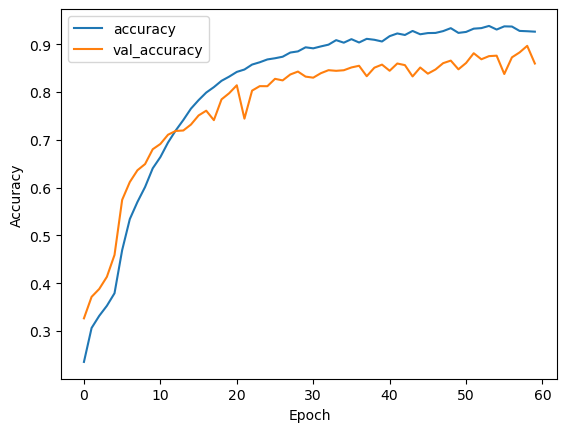

In [6]:
"""
Train model
"""
history_custom = custom_model.fit(train, validation_data=valid, epochs=epochs_total)

plt.plot(history_custom.history["accuracy"], label="accuracy")
plt.plot(history_custom.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
"""
Save model
"""
custom_model.save(f"{TF_MODELS_DIR}/{model_name}")

INFO:tensorflow:Assets written to: ../data/models_tf/DemooNet_8c_3d_60e_32b\assets


INFO:tensorflow:Assets written to: ../data/models_tf/DemooNet_8c_3d_60e_32b\assets


In [8]:
"""
Convert SavedModel (TensorFlow) to .tflite
"""
converter = tf.lite.TFLiteConverter.from_saved_model(f"{TF_MODELS_DIR}/{model_name}")
tflite_model = converter.convert()

with open(f"{TFLITE_MODELS_DIR}/{model_name}.tflite", "wb") as f:
  f.write(tflite_model)